# **MENTAL HEALTH INSURANCE**

This project delves into mental health insurance, aiming to predict whether an individual will seek mental health treatment. Through exploratory data analysis (EDA), we identified key factors influencing treatment-seeking behavior. Subsequently, a predictive model was developed to assess mental health risk factors. The analysis helps pinpoint the key factors that influence whether someone seeks treatment (whether a claim occurs) through the feature importances.

**OBJECTIVES**
1. Analyse the linguistic patterns, sentiments and mental health indicators in our dataset.
2. Assess mental health risk facors
3. Build a Random Forest Model to predict whether an individual seeks treatment.
4. Support product development



## **PREPARE DATA**

In [35]:
%pip -q install category-encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

We'll download the dataset from kaggle

In [3]:
# Create a .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download bhavikjikadara/mental-health-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 812MB/s]


In [5]:
!unzip -q mental-health-dataset.zip

We'll write a wrangle function that reads in our csv data from kaggle into our dataframe

In [41]:
def wrangle(filepath):

  # Read CSV file
  df = pd.read_csv(filepath)

  # Change names of columns to lowercase
  df.columns = df.columns.str.lower()

  # Drop "timestamp" column
  df = df.drop(columns="timestamp")

  # Convert 'treatment' feature to binary
  df['treatment'] = df['treatment'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

  # Drop column that may introduce bias into our model
  df = df.drop(columns="country")

  return df

In [42]:
df = wrangle("/content/Mental Health Dataset.csv")
print(df.shape)
df.head()

(292364, 15)


,gender,occupation,self_employed,family_history,treatment,days_indoors,growing_stress,changes_habits,mental_health_history,mood_swings,coping_struggles,work_interest,social_weakness,mental_health_interview,care_options
0,Female,Corporate,NaN,No,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,Female,Corporate,NaN,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,Female,Corporate,NaN,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,Female,Corporate,No,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,Female,Corporate,No,Yes,1,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


**INFORMATION ON OUR DATASET**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   gender                   292364 non-null  object
 1   occupation               292364 non-null  object
 2   self_employed            287162 non-null  object
 3   family_history           292364 non-null  object
 4   treatment                292364 non-null  object
 5   days_indoors             292364 non-null  object
 6   growing_stress           292364 non-null  object
 7   changes_habits           292364 non-null  object
 8   mental_health_history    292364 non-null  object
 9   mood_swings              292364 non-null  object
 10  coping_struggles         292364 non-null  object
 11  work_interest            292364 non-null  object
 12  social_weakness          292364 non-null  object
 13  mental_health_interview  292364 non-null  object
 14  care_options        

# **EXPLORE**

**Mental Health Treatment by Gender**

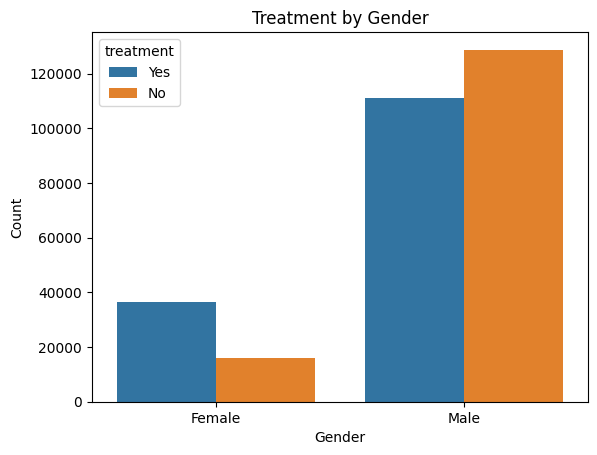

In [11]:
sns.countplot(x='gender', hue='treatment', data=df)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Treatment by Gender")
plt.show()

The analysis shows that females are more likely to seek mental health treatment compared to males, indicating a higher level of awareness or willingness to access care. In contrast, males represent a larger untreated group, which may point to stigma, underreporting, or limited access to mental health services. From an actuarial point of view, the aspect of higher female frequency can be used in pricing health or mental riders.

**Mental Health Treatment By Family History**

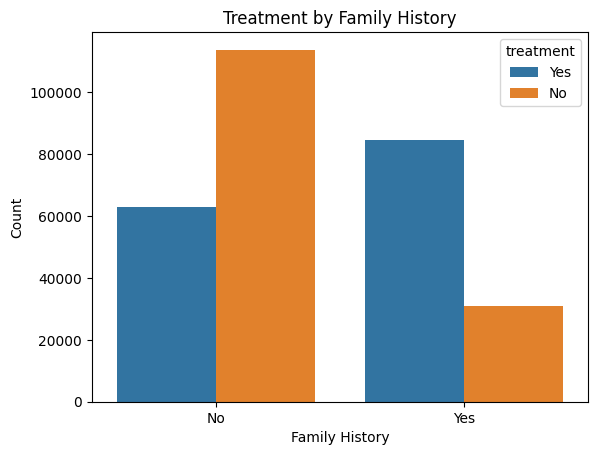

In [12]:
sns.countplot(data=df, x='family_history', hue='treatment')
plt.xlabel("Family History")
plt.ylabel("Count")
plt.title("Treatment by Family History")
plt.show()

Through the analysis, we observe a clear correlation between family history and mental health treatment. Individuals with a family history of mental health issues are more likely to seek treatment compared to those without such a background. This suggests that prior exposure increase the likelihood of recognizing symptoms and pursuing professional help, making family history a valuable predictor in determining whether someone seeks treatment

**Mental Health Treatment By Occupation**

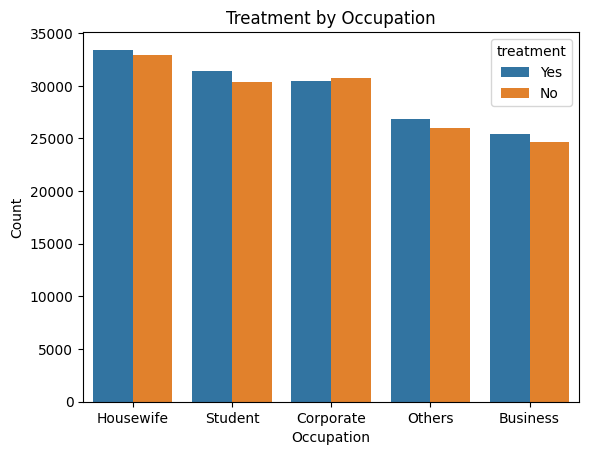

In [13]:
sns.countplot(x='occupation', hue='treatment', data=df, order=df['occupation'].value_counts().index)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Treatment by Occupation")
plt.show()

Occupation appears to influence treatment-seeking behavior, with housewives showing the highest uptake, suggesting a potentially higher claim frequency in this group. Corporate and student populations exhibit balanced treatment patterns, indicating stable utilization, while business professionals show comparatively lower engagement.

**Mental Health Treatment By Care Options**

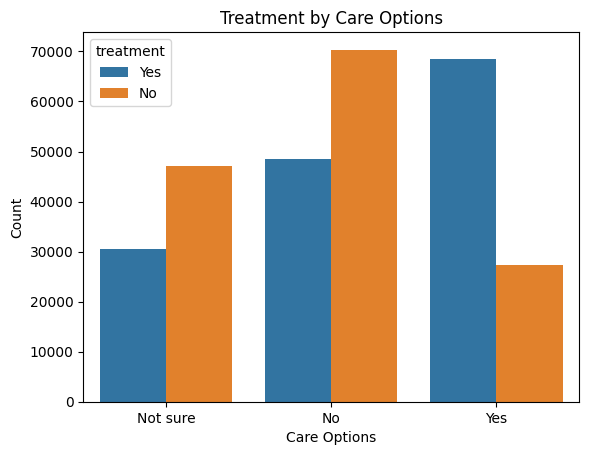

In [14]:
sns.countplot(x='care_options', hue='treatment', data=df)
plt.xlabel("Care Options")
plt.ylabel("Count")
plt.title("Treatment by Care Options")
plt.show()

Analysis shows a strong positive correlation between awareness or access to care options and actual treatment uptake. Individuals who indicated “Yes” to care options being available have the highest treatment uptake, significantly outpacing those who responded “No” or “Not sure.” Conversely, those unaware or doubtful about available care options are less likely to seek treatment.

From an actuarial standpoint, this highlights the critical role of care accessibility and awareness in influencing claim frequency. Policyholders who believe care is available are more likely to utilize their benefits, leading to higher claim counts.

**Mental Health Treatment By Self Employment**

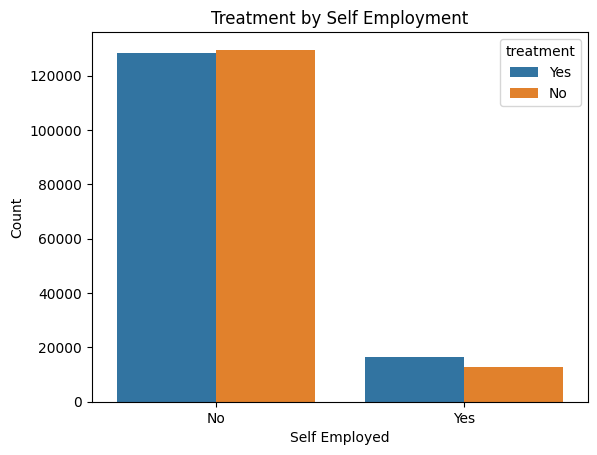

In [15]:
sns.countplot(x="self_employed" , hue='treatment', data=df)
plt.xlabel("Self Employed")
plt.ylabel("Count")
plt.title("Treatment by Self Employment")
plt.show()

The analysis suggests that self-employed individuals are likely to seek mental health treatment when needed. Although they represent a smaller proportion of the dataset, their treatment-seeking behavior highlights a potential demand for mental health products and services specifically designed to meet the unique needs of this group. This indicates an opportunity to develop targeted mental health support for self-employed professionals.

In [43]:
# Create pivot table
occupation_pivot = pd.pivot_table(
    df, index="mental_health_interview", values="treatment", aggfunc=np.mean
).sort_values(by="treatment")
occupation_pivot

,treatment
mental_health_interview,
Maybe,0.399193
No,0.526942
Yes,0.542672


**Class Balance**

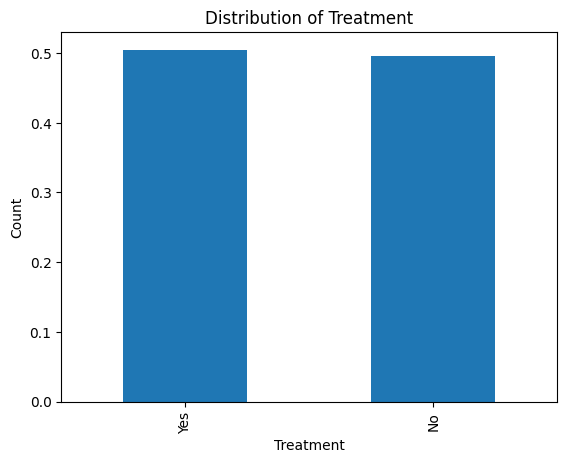

In [16]:
df["treatment"].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.title("Distribution of Treatment")
plt.show()

**SPLIT**

In [17]:
target = "treatment"
X = df.drop(columns=target)
y = df[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (233891, 14)
X_test.shape: (58473, 14)
y_train.shape: (233891,)
y_test.shape: (58473,)


## **BUILD MODEL**

**Baseline**

In [19]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", acc_baseline)

Baseline Accuracy: 0.5046282242583083


**Hyperparameter Tuning**

In [20]:
clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [22]:
params = {
    "randomforestclassifier__n_estimators": range(5, 35, 5),
    "randomforestclassifier__max_depth": range(5, 30, 5)

}
params

{'randomforestclassifier__n_estimators': range(5, 35, 5),
 'randomforestclassifier__max_depth': range(5, 30, 5)}

In [23]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 30, 5),
                         'randomforestclassifier__n_estimators': range(5, 35, 5)},
             verbose=1)

In [24]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 30, 5),
                         'randomforestclassifier__n_estimators': range(5, 35, 5)},
             verbose=1)

**Extract Model Results**

In [25]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.733975,0.510176,0.345899,0.039824,5,5,"{'randomforestclassifier__max_depth': 5, 'rand...",0.695782,0.701890,0.708474,0.691885,0.703664,0.700339,0.005863,17
1,2.894141,0.464495,0.374046,0.052201,5,10,"{'randomforestclassifier__max_depth': 5, 'rand...",0.706364,0.707213,0.703664,0.704797,0.702510,0.704910,0.001717,11
2,3.881480,0.911294,0.369635,0.039491,5,15,"{'randomforestclassifier__max_depth': 5, 'rand...",0.709806,0.713006,0.708923,0.710505,0.710035,0.710455,0.001375,10
3,3.772523,0.507990,0.457302,0.062825,5,20,"{'randomforestclassifier__max_depth': 5, 'rand...",0.710597,0.716127,0.712044,0.712899,0.709992,0.712332,0.002159,9
4,4.251648,0.540750,0.385340,0.074643,5,25,"{'randomforestclassifier__max_depth': 5, 'rand...",0.712029,0.716362,0.714887,0.714353,0.709479,0.713422,0.002415,8
5,4.434461,0.314250,0.470252,0.129307,5,30,"{'randomforestclassifier__max_depth': 5, 'rand...",0.712905,0.716811,0.715956,0.714780,0.710954,0.714281,0.002118,7
6,2.956466,0.389948,0.463216,0.161104,10,5,"{'randomforestclassifier__max_depth': 10, 'ran...",0.715599,0.721279,0.713605,0.713925,0.709479,0.714777,0.003824,6
7,3.218705,0.288797,0.398626,0.072898,10,10,"{'randomforestclassifier__max_depth': 10, 'ran...",0.718207,0.721921,0.717624,0.716149,0.714545,0.717689,0.002467,5
8,3.904203,0.442414,0.392794,0.017754,10,15,"{'randomforestclassifier__max_depth': 10, 'ran...",0.719746,0.722861,0.718906,0.717581,0.714887,0.718796,0.002615,4
9,4.904715,0.460530,0.443155,0.075455,10,20,"{'randomforestclassifier__max_depth': 10, 'ran...",0.720109,0.723866,0.719377,0.718137,0.715807,0.719459,0.002643,3


**Best Model**

In [26]:
model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 30}

## **EVALUATE**

In [27]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.7216
Test Accuracy: 0.7189


**Confusion Matrix Display**

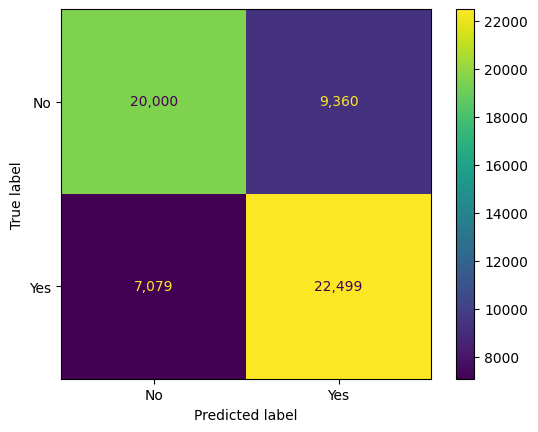

In [28]:
# Plot the confusion matrix display
conf_matrix_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

# Get the axes from the display object
ax = conf_matrix_display.figure_.axes[0]

# Iterate over the text items and format them
for text in ax.texts:
    float(text.get_text())
    text.set_text(f"{float(text.get_text()):,.0f}")
# Display the plot
plt.show()

**Classification Report**

In [29]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

          No       0.73      0.68      0.70     28895
         Yes       0.71      0.76      0.73     29578

    accuracy                           0.72     58473
   macro avg       0.72      0.72      0.72     58473
weighted avg       0.72      0.72      0.72     58473



## **COMMUNICATION**

**Feature Importances**

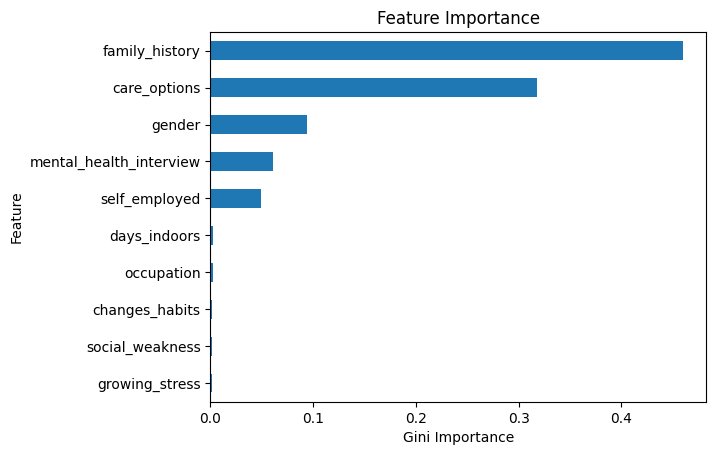

In [30]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

The are the top features that influence whether an individual will seek treatment